In [161]:
import os
import threading
import itertools
import random
import cv2
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

contours = []
correlations = []

def getImageFiles(directory):
    imageFiles = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.png'):
                imageFiles.append(os.path.join(root, file))
    return imageFiles

def compareContours(image1,image2):
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    _, thresh1 = cv2.threshold(gray1, 1, 255, cv2.THRESH_BINARY)
    _, thresh2 = cv2.threshold(gray2, 1, 255, cv2.THRESH_BINARY)

    # 寻找轮廓
    contours1, _ = cv2.findContours(thresh1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours2, _ = cv2.findContours(thresh2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours1 or not contours2:
        return None
    img1c = np.zeros_like(image1)
    img2c = np.zeros_like(image2)
    cv2.drawContours(img1c, contours1, -1, (0,255,0), 3)
    cv2.drawContours(img2c, contours2, -1, (0,255,0), 3)

    # 使用matchShapes函数比较轮廓
    imgCorrel = calculate_correlation(cv2.cvtColor(img1c, cv2.COLOR_BGR2GRAY),cv2.cvtColor(img2c, cv2.COLOR_BGR2GRAY))

    return imgCorrel

def veifyContours(image1,image2):

    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    _, thresh1 = cv2.threshold(gray1, 1, 255, cv2.THRESH_BINARY)
    _, thresh2 = cv2.threshold(gray2, 1, 255, cv2.THRESH_BINARY)



    # 寻找轮廓
    contours1, _ = cv2.findContours(thresh1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours2, _ = cv2.findContours(thresh2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(len(contours1))
    print(len(contours2))
    contour1 = contours1[0]
    contour2 = contours2[0]

    if not contours1 or not contours2:
        return None
    if len(contours1)!=1 or len(contours2)!=1:
        return None
    img1c = np.zeros_like(image1)
    img2c = np.zeros_like(image2)
    # 使用matchShapes函数比较轮廓
    similarity = cv2.matchShapes(contour1, contour2, cv2.CONTOURS_MATCH_I1, 0)
    cv2.drawContours(img1c, contours1, -1, (0,255,0), 3)
    cv2.drawContours(img2c, contours2, -1, (0,255,0), 3)
    correlation = calculate_correlation(cv2.cvtColor(img1c, cv2.COLOR_BGR2GRAY),cv2.cvtColor(img2c, cv2.COLOR_BGR2GRAY))

    return thresh1,thresh2,cv2.cvtColor(img1c, cv2.COLOR_BGR2RGB),cv2.cvtColor(img2c, cv2.COLOR_BGR2RGB),similarity,correlation

def calculate_correlation(image1, image2):
    # 将图像转换为浮点数并归一化
    image1_norm = image1.astype(np.float32) / 255.0
    image2_norm = image2.astype(np.float32) / 255.0

    # 计算图像的平均值和标准差
    mean1, std_dev1 = cv2.meanStdDev(image1_norm)
    mean2, std_dev2 = cv2.meanStdDev(image2_norm)

    # 检查除数是否为零或接近零
    eps = 1e-8
    if std_dev1 * std_dev2 < eps:
        return None
    else:
        covariance = cv2.mean((image1_norm - mean1) * (image2_norm - mean2))[0]
        correlation_coefficient = covariance / (std_dev1 * std_dev2)
    return abs(correlation_coefficient.item())




In [2]:
dir = "../ShapeNetCore_Depth"
imageFiles = getImageFiles(dir)

images = []
print("filecounter:"+str(len(imageFiles)))
for imageFile in imageFiles:
    images.append(cv2.imread(imageFile))

filecounter:24270


In [8]:
k = 20000
grid1, grid2 = np.meshgrid(np.linspace(0,len(images),len(images)).astype(int), np.linspace(0,len(images),len(images)).astype(int))
combinations = np.vstack([grid1.ravel(), grid2.ravel()]).T
print(combinations.shape)
indices = np.arange(combinations.shape[0])

print(len(images))
# 在索引上进行随机采样
random_indices = np.random.choice(indices, size=k, replace=False)

# 使用这些索引来获取组合
random_combinations = combinations[random_indices]
print("start"+str(len(random_combinations)))

(589032900, 2)
24270
start20000


In [163]:
for pair in tqdm(random_combinations):
    idx1,idx2 = pair[0],pair[1]
    c1 = compareContours(images[idx1],images[idx2])
    c2 = calculate_correlation(cv2.cvtColor(images[idx1], cv2.COLOR_BGR2GRAY),cv2.cvtColor(images[idx2], cv2.COLOR_BGR2GRAY))


    if c1 is not None and c2 is not None:
        contours.append(c1)
        correlations.append(c2)
print(len(correlations))
print(len(contours))




100%|██████████| 20000/20000 [00:54<00:00, 368.12it/s]

12151
12151


In [157]:
random_pair = random.choice(random_combinations)
idx1,idx2 = random_pair[0],random_pair[1]
c1 = compareContours(images[idx1],images[idx2])
c2 = calculate_correlation(cv2.cvtColor(images[idx1], cv2.COLOR_BGR2GRAY),cv2.cvtColor(images[idx2], cv2.COLOR_BGR2GRAY))
print(type(c1))
print(len(c1))
print(c1.shape)
list = []
list.append(c1)
print(len(list))
print(type(c2))
print(len(c2))
print(c2.shape)


<class 'NoneType'>


TypeError: object of type 'NoneType' has no len()

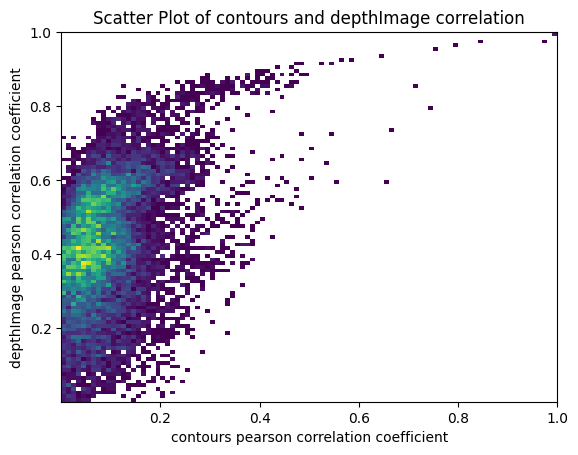

In [170]:
x = np.asarray(contours)
y = np.asarray(correlations)
plt.hist2d(x, y, bins=100,cmin = 1)
plt.xlabel('contours pearson correlation coefficient')
plt.ylabel('depthImage pearson correlation coefficient')
plt.title('Scatter Plot of contours and depthImage correlation')
plt.show()

In [130]:
random_pair = random.choice(random_combinations)
idx1,idx2 = random_pair[0],random_pair[1]
g1,g2,img1,img2,value,correlation = veifyContours(images[idx1],images[idx2])
plt.figure(figsize=(20,10))
plt.subplot(2, 4, 1)
plt.imshow(img1)
plt.subplot(2, 4, 2)
plt.imshow(img2)
plt.subplot(2, 4, 3)
plt.imshow(images[idx1])
plt.subplot(2, 4, 4)
plt.imshow(images[idx2])
plt.subplot(2, 4, 5)
plt.imshow(g1)
plt.subplot(2, 4, 6)
plt.imshow(g2)
print(value)
print(correlation)

2
1


TypeError: cannot unpack non-iterable NoneType object